# Scked generalization applied to a regression problem

This example shows how stacked generalization can be used to combine several
regressors into a single stacked one that performs better than the best
regressor.

The example uses the k-fold aproach to blending regressors on the inner layers.

We use Boston's house pricing dataset to compare the mean squared error between
three regressors (SVM, Lasso and Ridge regressions) and the combination of
their outputs with a single linear regression. The following result is
achieved.

In [1]:
# utils
from time import time

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

# import base regressors
from sklearn.linear_model import LassoCV, RidgeCV, LinearRegression
from sklearn.svm import SVR

# stacking api
from wolpert.pipeline import make_stack_layer
from wolpert.pipeline import StackingPipeline

# dataset
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

%matplotlib inline

RANDOM_SEED = 89555

MSE for Lasso Regressor: 22.913 (train time: 0.020 seconds)
MSE for Ridge Regressor: 21.699 (train time: 0.001 seconds)
MSE for SVR: 21.227 (train time: 0.074 seconds)
MSE for Stacked Regressors: 18.149 (train time: 0.254 seconds)


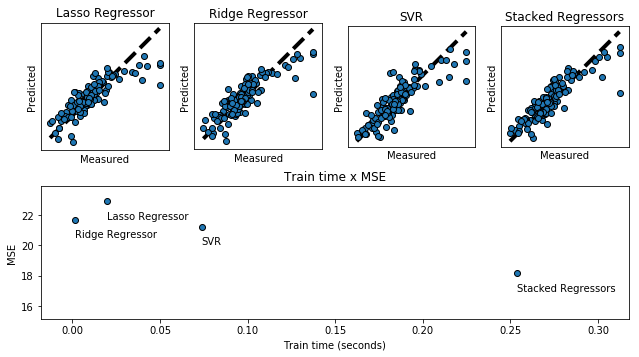

In [2]:
fig = plt.figure(figsize=(9, 5))
gs_outer = GridSpec(2, 1, wspace=0.1)

gs_regressors = GridSpecFromSubplotSpec(1, 4, subplot_spec=gs_outer[0])
regs_axarr = [plt.Subplot(fig, gridspec) for gridspec in gs_regressors]

time_ax = plt.Subplot(fig, gs_outer[1])

# prepare data
X, y = load_boston(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=RANDOM_SEED)

# Base regressors
lasso = LassoCV(random_state=RANDOM_SEED)
ridge = RidgeCV()
svr = SVR(C=1e3, gamma=1e-4, kernel='rbf')

base_regressors = [("Lasso Regressor", lasso),
                   ("Ridge Regressor", ridge),
                   ("SVR", svr)]


def evaluate_and_log_model(name, model, ax):
    t0_train = time()
    model.fit(X_train, y_train)
    train_time = time() - t0_train
    y_pred = model.predict(X_test)
    score = mean_squared_error(y_test, y_pred)
    print("MSE for %s: %.3f (train time: %.3f seconds)"
          % (name, score, train_time))

    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
            'k--', lw=4, zorder=1)
    ax.scatter(y_test, y_pred, edgecolors=(0, 0, 0), zorder=2)
    ax.set_title(name)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_aspect("equal")
    fig.add_subplot(ax)

    return train_time, score


train_times = []
scores = []
labels = [name for name, _ in base_regressors]

for i, (name, regressor) in enumerate(base_regressors):
    train_time, score = evaluate_and_log_model(name, regressor, regs_axarr[i])
    train_times.append(train_time)
    scores.append(score)

# Stacked ensemble: we use the base regressors as features for a new linear
# regressor.
layer0 = make_stack_layer(lasso, ridge, svr)
final_regressor = StackingPipeline([('layer0', layer0),
                                    ('metaestimator', LinearRegression())])

train_time, score = evaluate_and_log_model('Stacked Regressors',
                                           final_regressor, regs_axarr[-1])

train_times.append(train_time)
scores.append(score)
labels.append('Stacked Regressors')

time_ax.scatter(train_times, scores, edgecolors=[0, 0, 0])
time_ax.set_title("Train time x MSE")
time_ax.set_xlabel('Train time (seconds)')
time_ax.set_ylabel('MSE')
for i, label in enumerate(labels):
    time_ax.annotate(label, (train_times[i], scores[i]), xytext=(0, -20),
                     textcoords='offset points', ha='left', va='bottom',
                     annotation_clip=True)

time_ax.set_xlim(right=max(train_times) * 1.25)
time_ax.set_ylim(bottom=min(scores) - 3, top=max(scores) + 1)
fig.add_subplot(time_ax)

gs_outer.tight_layout(fig)